In [1]:
from numpy import cos, sin, pi, sqrt, arccos, log
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simplified_fun(x, y, N):
    #  the boundary is divided into N semgements, 
    #  each segment  end points xp,yp and xm, ym are elements of arrays 
    #  (xp[i],yp[i])__________(barx[i], bary[i])____________(xm[i], ym[i] 
    #  were barx and bary are coordinates of midpoints
    xp = x[1:]
    yp = y[1:]
    xm = x[:-1]
    ym = y[:-1]
    barx = 0.5 * (xp + xm)
    bary = 0.5 * (yp + ym)
    
    ds = sqrt((xp - xm) ** 2 + (yp - ym) ** 2)
    #Compute direction vectors
    directions = np.column_stack([xp - xm, yp - ym])
    # Rotate directions by 90 degrees to obtain normal vectors
    normals = np.column_stack([-directions[:, 1], directions[:, 0]])
    # Normalize normal vectors
    norms = np.linalg.norm(normals, axis=1)
    normals_normalized = normals / norms[:, np.newaxis]
    nn1 = normals_normalized[:, 0]
    nn2 = normals_normalized[:, 1]
    nn6 = barx*nn2 - bary*nn1

    hh1 = np.zeros(N)
    hh2 = np.zeros(N)
    hh6 = np.zeros(N)
    dtheta = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            a1 = xm[j] - barx[i]
            a2 = ym[j] - bary[i]
            b1 = xp[j] - barx[i]
            b2 = yp[j] - bary[i]

            # we constrain the argument between -1 and 1 to avoid numerical issues due to round-off errors
            ttemp = np.clip((a1 * b1 + a2 * b2) / sqrt( (a1**2 + a2**2) * (b1**2 + b2**2)), -1, 1)
            dtheta[i, j] = -arccos(ttemp)
            if j - i == 0:
                dtheta[i, j] = -pi # for m=n
            x1g = 0.5 * (xp[j] - xm[j]) / sqrt(3) + barx[j]
            y1g = 0.5 * (yp[j] - ym[j]) / sqrt(3) + bary[j]
            x2g = -0.5 * (xp[j] - xm[j]) / sqrt(3) + barx[j]
            y2g = -0.5 * (yp[j] - ym[j]) / sqrt(3) + bary[j]
            hh0 = log((x1g - barx[i])**2 + (y1g - bary[i])**2)
            hh0 = hh0 + log((x2g - barx[i])**2 + (y2g - bary[i])**2)
            hh0 = hh0 * 0.5
            hh1[i] += hh0 * nn1[j] * ds[j] / 2
            hh2[i] += hh0 * nn2[j] * ds[j] / 2
            hh6[i] += hh0 * nn6[j] * ds[j] / 2

    # the linear system is solved using a standard numpy linear algebra solver
    pdcr1 = (np.linalg.solve(dtheta, hh1))
    pdcr2 = (np.linalg.solve(dtheta, hh2))
    pdcr6 = (np.linalg.solve(dtheta, hh6))

    # finally we compute the added mass
    a11 = np.sum(pdcr1 * nn1 * ds)
    a22 = np.sum(pdcr2 * nn2 * ds)
    a66 = np.sum(pdcr6 * nn6 * ds)
   
    return pdcr1, [a11, a22, a66]

In [3]:
def solve(figure_type, a, b, number_of_elems):
    theta = np.arange(0, 2 * pi + 2*pi/number_of_elems, 2*pi/number_of_elems)
    bartheta = (theta[1::]+theta[0:-1])*0.5

    if figure_type == 'eclipse':
        r = a*b/sqrt((b*cos(theta))**2 + (a*sin(theta))**2)
        x = r*cos(theta)
        y = r*sin(theta)
        return simplified_fun(x,y,number_of_elems)

In [14]:
def elipse_m_ij_coeficents(semi_major_len, semi_minor_len, number_of_elems):
    pdcr, m_coef_numerical =  solve('eclipse', semi_major_len, semi_minor_len, number_of_elems)
        eccentricity = np.sqrt(1 - (semi_minor_len/semi_major_len)**2)
    m_coef_analytical = np.array([np.pi * semi_minor_len**2, np.pi * semi_major_len**2,
                                  0.125 *np.pi * (semi_major_len**2 - semi_minor_len**2)**2])
    accuracy_arr = m_coef_numerical/m_coef_analytical
    # the array of absolute errror values
    error_abs_arr = np.abs(m_coef_analytical - m_coef_numerical)
    # the array of normalized errror values
    error_norm_arr = error_abs_arr/m_coef_analytical*100
    print(f"b_0/a_0 ratio: {semi_minor_len/semi_major_len}")
    print(f"eccentricity {eccentricity}")
    print("analytical mij", m_coef_analytical)
    print("numerical mij", m_coef_numerical )
    print("absolute error mij", error_abs_arr )
    print("normalized error mij", error_norm_arr )
    print()
    return pdcr, accuracy_arr


In [5]:
def plot_accuracy(y_label_text, accuracy_list, resolution_list):
    plt.title('Added mass coefficent accuracy ratio as a function of the inverse of resolution', pad = 20)
    _ = plt.plot(resolution_list, accuracy_list,  '.r', markersize=10, label = 'analytical solution')
    plt.xlabel('1/N')
    plt.ylabel(y_label_text, rotation='vertical', labelpad=30)
    plt.grid(True)

In [6]:
num_of_elems_list = np.array([100,200,400])
#num_of_elems_list = np.array([100,200])

side_length = 1
accuracy_matrix = np.empty((0, 3))
for n_elem in num_of_elems_list:
    pdcr, accuracy_list = elipse_m_ij_coeficents(2,1, n_elem)
    accuracy_matrix = np.vstack([accuracy_matrix, accuracy_list])
accuracy_matrix

b_0/a_0 ratio: 0.5
eccentricity 0.8660254037844386
[ 3.14159265 12.56637061  3.53429174]
[3.1106137501591418, 12.4055562218459, 3.4390460608604263]

b_0/a_0 ratio: 0.5
eccentricity 0.8660254037844386
[ 3.14159265 12.56637061  3.53429174]
[3.1251639762484085, 12.48867188905533, 3.487869440661444]

b_0/a_0 ratio: 0.5
eccentricity 0.8660254037844386
[ 3.14159265 12.56637061  3.53429174]
[3.133137966928038, 12.528207612879935, 3.511391183671141]



array([[0.99013911, 0.9872028 , 0.97305099],
       [0.99477059, 0.99381693, 0.98686518],
       [0.99730879, 0.99696308, 0.99352047]])

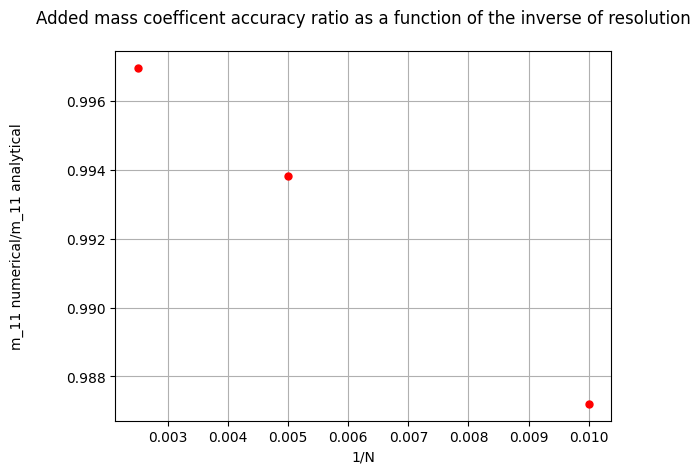

In [9]:
m11_accuracy = accuracy_matrix[:,1]
plot_accuracy("m_11 numerical/m_11 analytical", m11_accuracy, 1/num_of_elems_list)

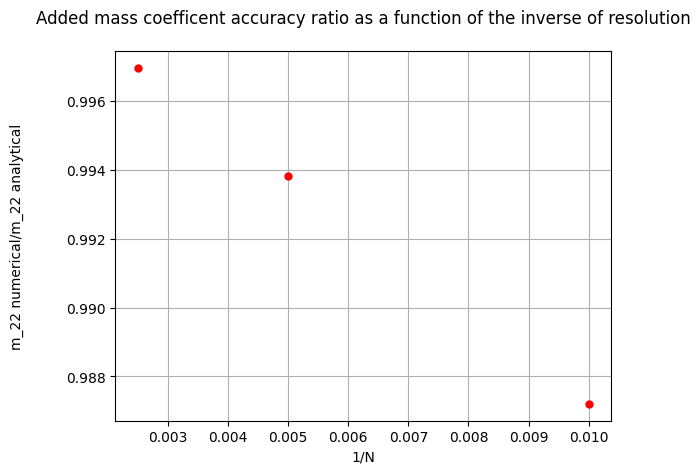

In [10]:
m22_accuracy = accuracy_matrix[:,1]
plot_accuracy("m_22 numerical/m_22 analytical", m22_accuracy, 1/num_of_elems_list)

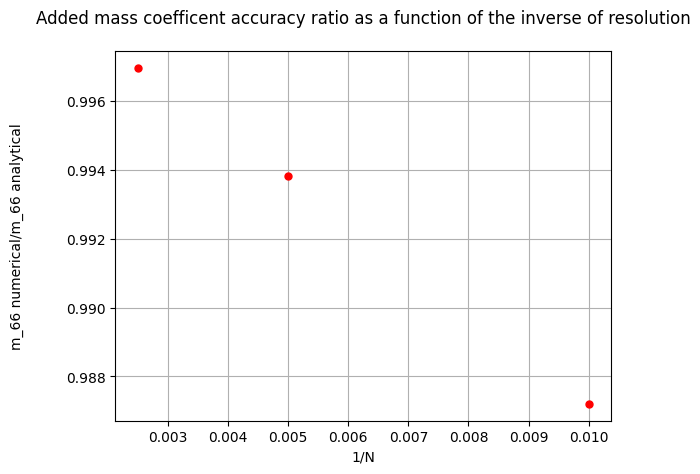

In [11]:
m66_accuracy = accuracy_matrix[:,1]
plot_accuracy("m_66 numerical/m_66 analytical", m66_accuracy, 1/num_of_elems_list)

In [16]:
num_of_elems_list = np.array([100,200,400])
#num_of_elems_list = np.array([100,200])

side_length = 1
accuracy_matrix = np.empty((0, 3))
for n_elem in num_of_elems_list:
    pdcr, accuracy_list = elipse_m_ij_coeficents(10,1, n_elem)
    accuracy_matrix = np.vstack([accuracy_matrix, accuracy_list])
accuracy_matrix

b_0/a_0 ratio: 0.1
eccentricity 0.99498743710662
analytical mij [   3.14159265  314.15926536 3848.84369973]
numerical mij [3.0773487950999114, 281.51615733748315, 3063.1751496975257]
absolute error mij [  0.06424386  32.64310802 785.66855003]
normalized error mij [ 2.04494553 10.390624   20.41310615]

b_0/a_0 ratio: 0.1
eccentricity 0.99498743710662
analytical mij [   3.14159265  314.15926536 3848.84369973]
numerical mij [3.109597429380822, 295.9417815334764, 3394.598720956099]
absolute error mij [  0.03199522  18.21748383 454.24497877]
normalized error mij [ 1.01843962  5.7988052  11.8021155 ]

b_0/a_0 ratio: 0.1
eccentricity 0.99498743710662
analytical mij [   3.14159265  314.15926536 3848.84369973]
numerical mij [3.12013823318053, 304.43401644571446, 3599.7229017121213]
absolute error mij [  0.02145442   9.72524891 249.12079802]
normalized error mij [0.68291541 3.09564287 6.47261405]



array([[0.97955054, 0.89609376, 0.79586894],
       [0.9898156 , 0.94201195, 0.88197885],
       [0.99317085, 0.96904357, 0.93527386]])

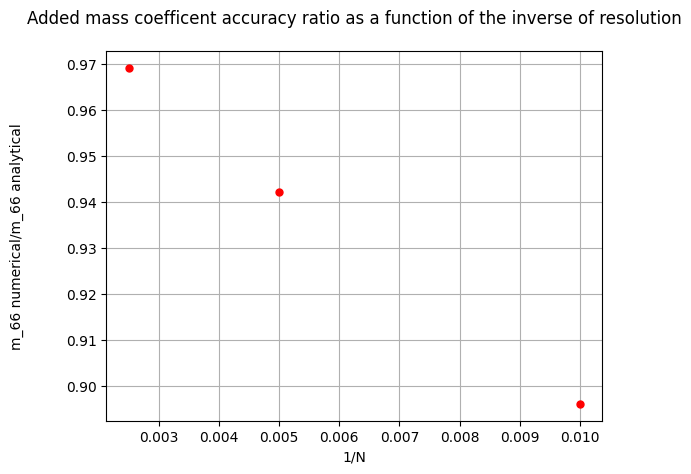

In [17]:
m66_accuracy = accuracy_matrix[:,1]
plot_accuracy("m_66 numerical/m_66 analytical", m66_accuracy, 1/num_of_elems_list)

In [15]:
np.set_printoptions(suppress=True)
number_of_elems = 100
elipse_m_ij_coeficents(2, 1, number_of_elems)
elipse_m_ij_coeficents(10, 1, number_of_elems)
elipse_m_ij_coeficents(100, 1, number_of_elems)

b_0/a_0 ratio: 0.5
eccentricity 0.8660254037844386
analytical mij [ 3.14159265 12.56637061  3.53429174]
numerical mij [3.1106137501591418, 12.4055562218459, 3.4390460608604263]
absolute error mij [0.0309789  0.16081439 0.09524567]
normalized error mij [0.98608912 1.27972027 2.69490131]

b_0/a_0 ratio: 0.1
eccentricity 0.99498743710662
analytical mij [   3.14159265  314.15926536 3848.84369973]
numerical mij [3.0773487950999114, 281.51615733748315, 3063.1751496975257]
absolute error mij [  0.06424386  32.64310802 785.66855003]
normalized error mij [ 2.04494553 10.390624   20.41310615]

b_0/a_0 ratio: 0.01
eccentricity 0.9999499987499375
analytical mij [       3.14159265    31415.9265359  39262054.58093752]
numerical mij [1.9420620896120346, 3038.288744114407, 1471320.560935514]
absolute error mij [       1.19953056    28377.63779178 37790734.02000201]
normalized error mij [38.18224373 90.32882656 96.25256351]



(array([-0.48989306, -0.15900178, -0.08866277, -0.06268805, -0.04812852,
        -0.03878654, -0.03224254, -0.02736901, -0.02357157, -0.02050714,
        -0.01796366, -0.01580286, -0.0139306 , -0.01228045, -0.01080407,
        -0.00946531, -0.00823652, -0.00709602, -0.00602647, -0.00501368,
        -0.00404582, -0.00311274, -0.00220558, -0.00131634, -0.00043762,
         0.00043762,  0.00131634,  0.00220558,  0.00311274,  0.00404582,
         0.00501368,  0.00602647,  0.00709602,  0.00823652,  0.00946531,
         0.01080407,  0.01228045,  0.0139306 ,  0.01580286,  0.01796366,
         0.02050714,  0.02357157,  0.02736901,  0.03224254,  0.03878654,
         0.04812852,  0.06268805,  0.08866277,  0.15900178,  0.48989306,
         0.48989306,  0.15900178,  0.08866277,  0.06268805,  0.04812852,
         0.03878654,  0.03224254,  0.02736901,  0.02357157,  0.02050714,
         0.01796366,  0.01580286,  0.0139306 ,  0.01228045,  0.01080407,
         0.00946531,  0.00823652,  0.00709602,  0.0